## Predicting phonon DoS
### Deep Learning on Graph Neural Neworks
By: Angelica Loshak, Kai Orita, Mikhail Scokalo 

In [31]:
!git clone https://github.com/ninarina12/phononDoS_tutorial.git
%cd phononDoS_tutorial

Cloning into 'phononDoS_tutorial'...
remote: Enumerating objects: 312, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 312 (delta 7), reused 12 (delta 4), pack-reused 294 (from 1)
Receiving objects: 100% (312/312), 83.18 MiB | 19.99 MiB/s, done.
Resolving deltas: 100% (160/160), done.
/home/angelica/Documents/Angelica/Rpi/Semesters/Rhone/phononDoS_tutorial/phononDoS_tutorial/phononDoS_tutorial


/home/angelica/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [30]:
!pip install ase e3nn
!pip install torch-scatter torch-cluster torch-sparse torch-spline-conv -f https://pytorch-geometric.com/whl/torch-$(python -c "import torch; print(torch.__version__)").html
!pip install torch-geometric
!pip install pickleshare

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: dblatex 0.3.11py3 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of dblatex or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
DEPRECATION: dblatex 0.3.11py3 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of dblatex or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at htt

In [33]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import torch_scatter
import e3nn
from e3nn import o3
from typing import Dict, Union

# crystal structure data
from ase import Atom, Atoms
from ase.neighborlist import neighbor_list
from ase.visualize.plot import plot_atoms

# data pre-processing and visualization
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# utilities
import time
from tqdm import tqdm
from utils.utils_data import (load_data, train_valid_test_split, plot_example, plot_predictions, plot_partials,
                              palette, colors, cmap)
from utils.utils_model import Network, visualize_layers, train
from utils.utils_plot import plotly_surface, plot_orbitals, get_middle_feats

bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

### Data provenance
We train our model using the database of Density Functional Perturbation Theory (DFPT)-calculated phonon densities of states (DoS), containing approximately 1,500 crystalline solids [[Petretto et al. 2018]](https://doi.org/10.1038/sdata.2018.65).

In [34]:
# load data
df, species = load_data('data/data.csv')
df.head()

100%|██████████| 1522/1522 [00:00<00:00, 28720.23it/s]                          


,mp_id,structure,phfreq,phdos,pdos,formula,species
0,mp-1000,"(Atom('Ba', [0.0, 0.0, 0.0], index=0), Atom('T...","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.0, 0.1603814665137704, 0.366293016390463, 0...","{'Ba': [0.0, 0.17004785173719497, 0.4321591874...",BaTe,"[Te, Ba]"
1,mp-1002124,"(Atom('Hf', [0.0, 0.0, 0.0], index=0), Atom('C...","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.02337731725373556, 0.030910686260937723, 0....","{'Hf': [0.026541048236378005, 0.03587084551615...",CHf,"[Hf, C]"
2,mp-1002164,"(Atom('Ge', [0.0, 0.0, 0.0], index=0), Atom('C...","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.0, 0.0017221473876927959, 0.005981246148731...","{'Ge': [0.0, 0.00316167053214679, 0.0109190651...",CGe,"[Ge, C]"
3,mp-10044,"(Atom('B', [4.440892098500626e-16, 6.194849927...","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.0, 0.002277293012378372, 0.0078646582782471...","{'B': [0.0, 0.00029269193672558846, 0.00105324...",AsB,"[As, B]"
4,mp-1008223,"(Atom('Ca', [0.0, 0.0, 0.0], index=0), Atom('S...","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.0, 0.258870972416879, 0.5505201512544314, 0...","{'Ca': [0.0, 0.11150000312651394, 0.2215562000...",CaSe,"[Se, Ca]"


### Data structures
Crystal structures are represented as [ASE](https://wiki.fysik.dtu.dk/ase/ase/atoms.html?highlight=atoms#the-atoms-object) (Atomic Simulation Environment) `Atoms` objects, which store the atomic species and positions of each atom in the unit cell, as well as the lattice vectors of the unit cell.

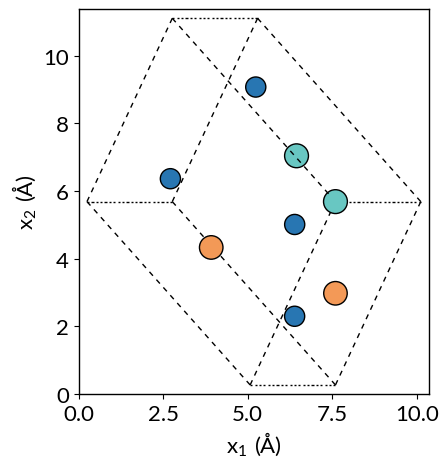

In [35]:
# plot an example structure
i = 12 # structure index in dataframe

struct = df.iloc[i]['structure']
symbols = np.unique(list(struct.symbols))
z = dict(zip(symbols, range(len(symbols))))

fig, ax = plt.subplots(figsize=(6,5))
norm = plt.Normalize(vmin=0, vmax=len(symbols)-1)
color = [mpl.colors.to_hex(k) for k in cmap(norm([z[j] for j in list(struct.symbols)]))]
plot_atoms(struct, ax, radii=0.25, colors=color, rotation=('0x,90y,0z'))

ax.set_xlabel(r'$x_1\ (\AA)$')
ax.set_ylabel(r'$x_2\ (\AA)$');

average lattice parameter (a/b/c): 4.913216585660792 / 5.258921900844212 / 6.5187904554067595


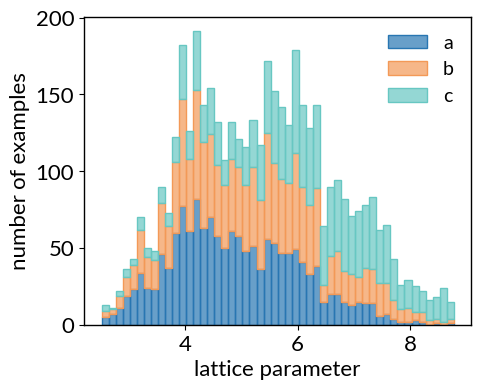

In [36]:
# lattice parameter statistics
def get_lattice_parameters(df):
    a = []
    for entry in df.itertuples():
        a.append(entry.structure.cell.cellpar()[:3])
    return np.stack(a)

a = get_lattice_parameters(df)

fig, ax = plt.subplots(1,1, figsize=(5,4))
b = 0.
bins = 50
for d, c, n in zip(['a', 'b', 'c'], colors.values(), [a[:,0], a[:,1], a[:,2]]):
    color = [int(c.lstrip('#')[i:i+2], 16)/255. for i in (0,2,4)]
    y, bins, _, = ax.hist(n, bins=bins, fc=color+[0.7], ec=color, bottom=b, label=d)
    b += y
ax.set_xlabel('lattice parameter')
ax.set_ylabel('number of examples')
ax.legend(frameon=False)

print('average lattice parameter (a/b/c):', a[:,0].mean(), '/', a[:,1].mean(), '/', a[:,2].mean())

### Feature representation
We construct the inputs to our neural network following the `e3nn` [Documentation](https://docs.e3nn.org/en/latest/guide/periodic_boundary_conditions.html) on handling point inputs with periodic boundary conditions. For a given crystal, each atom in the unit cell is associated with a feature vector that one-hot encodes its atomic mass in the index corresponding to its atomic number. The unit cell of the crystal is encoded as a graph in which two atoms (nodes) are joined by an edge if they are within a cutoff radius `r_max` of one another.

In [37]:
# one-hot encoding atom type and mass
type_encoding = {}
specie_am = []
for Z in tqdm(range(1, 119), bar_format=bar_format):
    specie = Atom(Z)
    type_encoding[specie.symbol] = Z - 1
    specie_am.append(specie.mass)

type_onehot = torch.eye(len(type_encoding))
am_onehot = torch.diag(torch.tensor(specie_am))

100%|██████████| 118/118 [00:00<00:00, 150571.30it/s]                           


In [38]:
# build data
def build_data(entry, type_encoding, type_onehot, r_max=5.):
    symbols = list(entry.structure.symbols).copy()
    positions = torch.from_numpy(entry.structure.positions.copy())
    lattice = torch.from_numpy(entry.structure.cell.array.copy()).unsqueeze(0)

    # edge_src and edge_dst are the indices of the central and neighboring atom, respectively
    # edge_shift indicates whether the neighbors are in different images or copies of the unit cell
    edge_src, edge_dst, edge_shift = neighbor_list("ijS", a=entry.structure, cutoff=r_max, self_interaction=True)
    
    # compute the relative distances and unit cell shifts from periodic boundaries
    edge_batch = positions.new_zeros(positions.shape[0], dtype=torch.long)[torch.from_numpy(edge_src)]
    edge_vec = (positions[torch.from_numpy(edge_dst)]
                - positions[torch.from_numpy(edge_src)]
                + torch.einsum('ni,nij->nj', torch.tensor(edge_shift, dtype=default_dtype), lattice[edge_batch]))

    # compute edge lengths (rounded only for plotting purposes)
    edge_len = np.around(edge_vec.norm(dim=1).numpy(), decimals=2)
    
    data = tg.data.Data(
        pos=positions, lattice=lattice, symbol=symbols,
        x=am_onehot[[type_encoding[specie] for specie in symbols]],   # atomic mass (node feature)
        z=type_onehot[[type_encoding[specie] for specie in symbols]], # atom type (node attribute)
        edge_index=torch.stack([torch.LongTensor(edge_src), torch.LongTensor(edge_dst)], dim=0),
        edge_shift=torch.tensor(edge_shift, dtype=default_dtype),
        edge_vec=edge_vec, edge_len=edge_len,
        phdos=torch.from_numpy(entry.phdos).unsqueeze(0)
    )
    
    return data

r_max = 4. # cutoff radius
df['data'] = df.progress_apply(lambda x: build_data(x, type_encoding, type_onehot, r_max), axis=1)

100%|██████████| 1522/1522 [00:16<00:00, 92.48it/s]                             


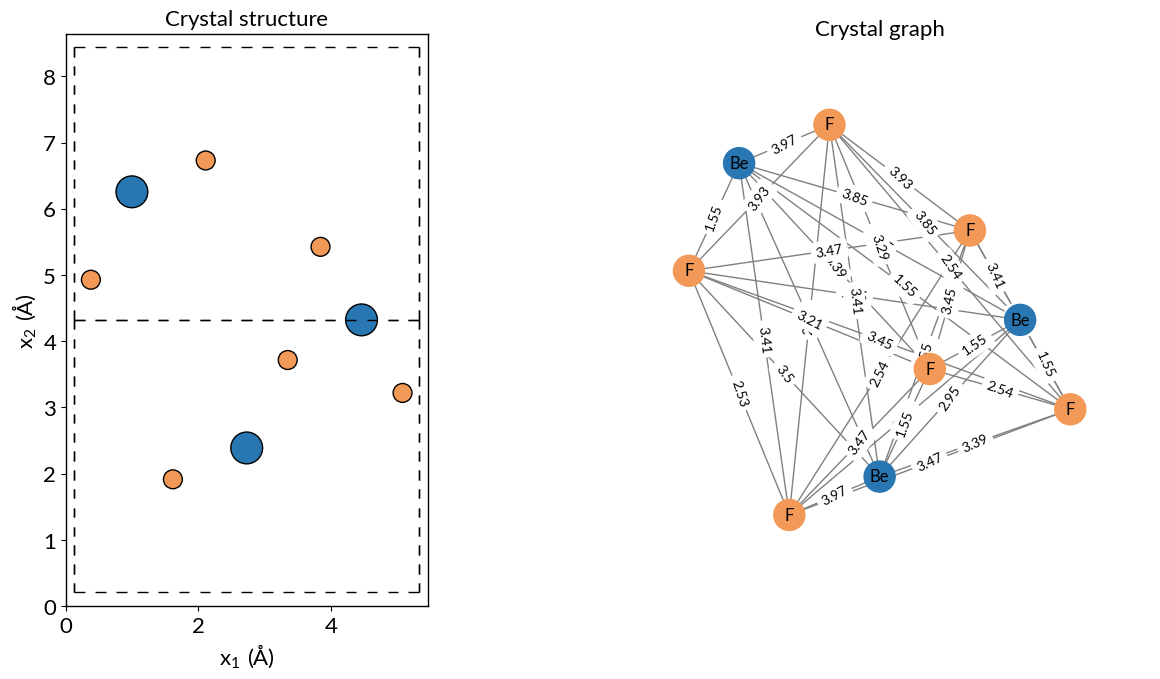

In [39]:
i = 244 # structure index in dataframe
plot_example(df, i=i, label_edges=True)

### Training, validation, and testing datasets
Split the data into training, validation, and testing datasets with balanced representation of different elements in each set.

split train/dev ...


100%|██████████| 64/64 [00:00<00:00, 301.15it/s]                                


split valid/test ...


100%|██████████| 62/62 [00:00<00:00, 385.15it/s]                                


number of training examples: 1192
number of validation examples: 141
number of testing examples: 189
total number of examples: 1522


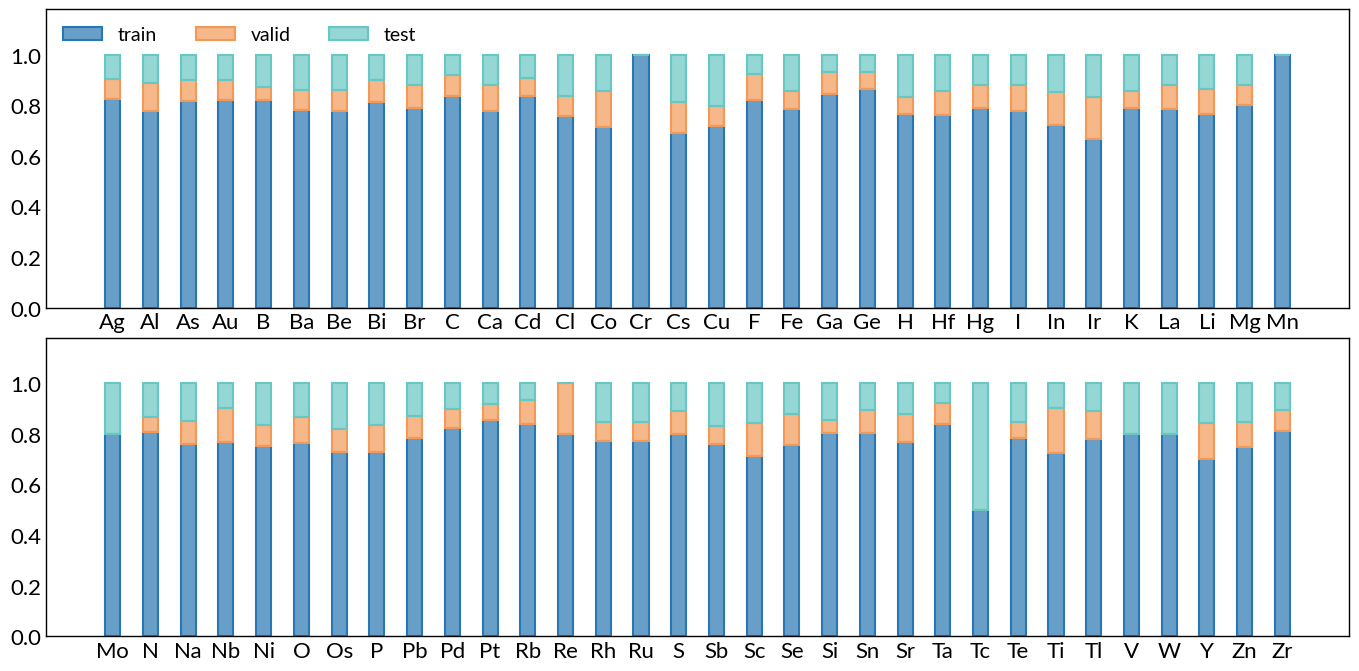

In [40]:
# train/valid/test split
idx_train, idx_valid, idx_test = train_valid_test_split(df, species, valid_size=.1, test_size=.1, seed=12, plot=True)

For use with the trained model provided, the indices of the training, validation, and test sets are loaded below. These indices were generated with a specific seed using the above `train_valid_test_split` function.

In [41]:
# load train/valid/test indices
with open('data/idx_train.txt', 'r') as f: idx_train = [int(i.split('\n')[0]) for i in f.readlines()]
with open('data/idx_valid.txt', 'r') as f: idx_valid = [int(i.split('\n')[0]) for i in f.readlines()]
with open('data/idx_test.txt', 'r') as f: idx_test = [int(i.split('\n')[0]) for i in f.readlines()]

# format dataloaders
batch_size = 1
dataloader_train = tg.loader.DataLoader(df.iloc[idx_train]['data'].values, batch_size=batch_size, shuffle=True)
dataloader_valid = tg.loader.DataLoader(df.iloc[idx_valid]['data'].values, batch_size=batch_size)
dataloader_test = tg.loader.DataLoader(df.iloc[idx_test]['data'].values, batch_size=batch_size)

average number of neighbors (train/valid/test): 15.837087001257574 / 15.272818455366098 / 15.455339153794492


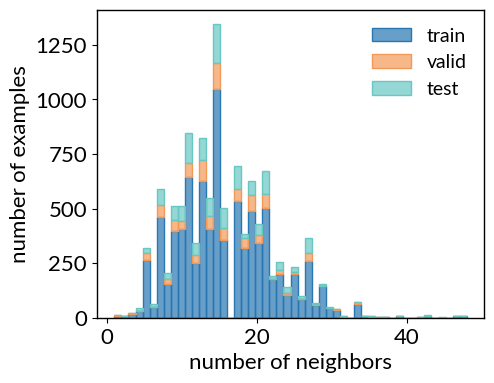

In [42]:
# calculate average number of neighbors
def get_neighbors(df, idx):
    n = []
    for entry in df.iloc[idx].itertuples():
        N = entry.data.pos.shape[0]
        for i in range(N):
            n.append(len((entry.data.edge_index[0] == i).nonzero()))
    return np.array(n)

n_train = get_neighbors(df, idx_train)
n_valid = get_neighbors(df, idx_valid)
n_test = get_neighbors(df, idx_test)

fig, ax = plt.subplots(1,1, figsize=(5,4))
b = 0.
bins = 50
for (d, c), n in zip(colors.items(), [n_train, n_valid, n_test]):
    color = [int(c.lstrip('#')[i:i+2], 16)/255. for i in (0,2,4)]
    y, bins, _, = ax.hist(n, bins=bins, fc=color+[0.7], ec=color, bottom=b, label=d)
    b += y
ax.set_xlabel('number of neighbors')
ax.set_ylabel('number of examples')
ax.legend(frameon=False)

print('average number of neighbors (train/valid/test):', n_train.mean(), '/', n_valid.mean(), '/', n_test.mean())

# Model

In [68]:
from typing import Dict, Union

import torch
from torch_geometric.data import Data
from torch_cluster import radius_graph

from e3nn import o3
from e3nn.math import soft_one_hot_linspace
from e3nn.nn import Gate
from e3nn.nn.models.gate_points_2101 import Convolution, smooth_cutoff, tp_path_exists

import matplotlib.pyplot as plt
import math
import time
from tqdm import tqdm

# format progress bar
bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'


# standard formatting for plots
fontsize = 16
textsize = 14
sub = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
plt.rcParams['font.family'] = 'lato'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['font.size'] = fontsize
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['legend.fontsize'] = textsize


class CustomCompose(torch.nn.Module):
    def __init__(self, first, second):
        super().__init__()
        self.first = first
        self.second = second
        self.irreps_in = self.first.irreps_in
        self.irreps_out = self.second.irreps_out

    def forward(self, *input):
        x = self.first(*input)
        self.first_out = x.clone()
        x = self.second(x)
        self.second_out = x.clone()
        return x


class Network(torch.nn.Module):
    r"""equivariant neural network
    Parameters
    ----------
    irreps_in : `e3nn.o3.Irreps` or None
        representation of the input features
        can be set to ``None`` if nodes don't have input features
    irreps_hidden : `e3nn.o3.Irreps`
        representation of the hidden features
    irreps_out : `e3nn.o3.Irreps`
        representation of the output features
    irreps_node_attr : `e3nn.o3.Irreps` or None
        representation of the nodes attributes
        can be set to ``None`` if nodes don't have attributes
    irreps_edge_attr : `e3nn.o3.Irreps`
        representation of the edge attributes
        the edge attributes are :math:`h(r) Y(\vec r / r)`
        where :math:`h` is a smooth function that goes to zero at ``max_radius``
        and :math:`Y` are the spherical harmonics polynomials
    layers : int
        number of gates (non linearities)
    max_radius : float
        maximum radius for the convolution
    number_of_basis : int
        number of basis on which the edge length are projected
    radial_layers : int
        number of hidden layers in the radial fully connected network
    radial_neurons : int
        number of neurons in the hidden layers of the radial fully connected network
    num_neighbors : float
        typical number of nodes at a distance ``max_radius``
    num_nodes : float
        typical number of nodes in a graph
    """
    def __init__(
        self,
        irreps_in,
        irreps_out,
        irreps_node_attr,
        layers,
        mul,
        lmax,
        max_radius,
        number_of_basis=10,
        radial_layers=1,
        radial_neurons=100,
        num_neighbors=1.,
        num_nodes=1.,
        reduce_output=True,
    ) -> None:
        super().__init__()
        self.mul = mul
        self.lmax = lmax
        self.max_radius = max_radius
        self.number_of_basis = number_of_basis
        self.num_neighbors = num_neighbors
        self.num_nodes = num_nodes
        self.reduce_output = reduce_output

        self.irreps_in = o3.Irreps(irreps_in) if irreps_in is not None else None
        self.irreps_hidden = o3.Irreps([(self.mul, (l, p)) for l in range(lmax + 1) for p in [-1, 1]])
        self.irreps_out = o3.Irreps(irreps_out)
        self.irreps_node_attr = o3.Irreps(irreps_node_attr) if irreps_node_attr is not None else o3.Irreps("0e")
        self.irreps_edge_attr = o3.Irreps.spherical_harmonics(lmax)

        self.input_has_node_in = (irreps_in is not None)
        self.input_has_node_attr = (irreps_node_attr is not None)

        irreps = self.irreps_in if self.irreps_in is not None else o3.Irreps("0e")

        act = {
            1: torch.nn.functional.silu,
            -1: torch.tanh,
        }
        act_gates = {
            1: torch.sigmoid,
            -1: torch.tanh,
        }

        self.layers = torch.nn.ModuleList()

        for _ in range(layers):
            irreps_scalars = o3.Irreps([(mul, ir) for mul, ir in self.irreps_hidden if ir.l == 0 and tp_path_exists(irreps, self.irreps_edge_attr, ir)])
            irreps_gated = o3.Irreps([(mul, ir) for mul, ir in self.irreps_hidden if ir.l > 0 and tp_path_exists(irreps, self.irreps_edge_attr, ir)])
            ir = "0e" if tp_path_exists(irreps, self.irreps_edge_attr, "0e") else "0o"
            irreps_gates = o3.Irreps([(mul, ir) for mul, _ in irreps_gated])

            gate = Gate(
                irreps_scalars, [act[ir.p] for _, ir in irreps_scalars],  # scalar
                irreps_gates, [act_gates[ir.p] for _, ir in irreps_gates],  # gates (scalars)
                irreps_gated  # gated tensors
            )
            conv = Convolution(
                irreps,
                self.irreps_node_attr,
                self.irreps_edge_attr,
                gate.irreps_in,
                number_of_basis,
                radial_layers,
                radial_neurons,
                num_neighbors
            )
            irreps = gate.irreps_out
            self.layers.append(CustomCompose(conv, gate))

        self.layers.append(
            Convolution(
                irreps,
                self.irreps_node_attr,
                self.irreps_edge_attr,
                self.irreps_out,
                number_of_basis,
                radial_layers,
                radial_neurons,
                num_neighbors
            )
        )

    def preprocess(self, data: Union[Data, Dict[str, torch.Tensor]]) -> torch.Tensor:
        if 'batch' in data:
            batch = data['batch']
        else:
            batch = data['pos'].new_zeros(data['pos'].shape[0], dtype=torch.long)

        if 'edge_index' in data:
            edge_src = data['edge_index'][0]  # edge source
            edge_dst = data['edge_index'][1]  # edge destination
            edge_vec = data['edge_vec']
        
        else:
            edge_index = radius_graph(data['pos'], self.max_radius, batch)
            edge_src = edge_index[0]
            edge_dst = edge_index[1]
            edge_vec = data['pos'][edge_src] - data['pos'][edge_dst]

        return batch, edge_src, edge_dst, edge_vec

    def forward(self, data: Union[Data, Dict[str, torch.Tensor]]) -> torch.Tensor:
        """evaluate the network
        Parameters
        ----------
        data : `torch_geometric.data.Data` or dict
            data object containing
            - ``pos`` the position of the nodes (atoms)
            - ``x`` the input features of the nodes, optional
            - ``z`` the attributes of the nodes, for instance the atom type, optional
            - ``batch`` the graph to which the node belong, optional
        """
        batch, edge_src, edge_dst, edge_vec = self.preprocess(data)
        edge_sh = o3.spherical_harmonics(self.irreps_edge_attr, edge_vec, True, normalization='component')
        edge_length = edge_vec.norm(dim=1)
        edge_length_embedded = soft_one_hot_linspace(
            x=edge_length,
            start=0.0,
            end=self.max_radius,
            number=self.number_of_basis,
            basis='gaussian',
            cutoff=False
        ).mul(self.number_of_basis**0.5)
        edge_attr = smooth_cutoff(edge_length / self.max_radius)[:, None] * edge_sh

        if self.input_has_node_in and 'x' in data:
            assert self.irreps_in is not None
            x = data['x']
        else:
            assert self.irreps_in is None
            x = data['pos'].new_ones((data['pos'].shape[0], 1))

        if self.input_has_node_attr and 'z' in data:
            z = data['z']
        else:
            assert self.irreps_node_attr == o3.Irreps("0e")
            z = data['pos'].new_ones((data['pos'].shape[0], 1))

        for lay in self.layers:
            x = lay(x, z, edge_src, edge_dst, edge_attr, edge_length_embedded)

        if self.reduce_output:
            return scatter(x, batch, dim=0).div(self.num_nodes**0.5)
        else:
            return x


def visualize_layers(model):
    layer_dst = dict(zip(['sc', 'lin1', 'tp', 'lin2'], ['gate', 'tp', 'lin2', 'gate']))
    try: layers = model.mp.layers
    except: layers = model.layers

    num_layers = len(layers)
    num_ops = max([len([k for k in list(layers[i].first._modules.keys()) if k not in ['fc', 'alpha']])
                   for i in range(num_layers-1)])

    fig, ax = plt.subplots(num_layers, num_ops, figsize=(14,3.5*num_layers))
    for i in range(num_layers - 1):
        ops = layers[i].first._modules.copy()
        ops.pop('fc', None); ops.pop('alpha', None)
        for j, (k, v) in enumerate(ops.items()):
            ax[i,j].set_title(k, fontsize=textsize)
            v.cpu().visualize(ax=ax[i,j])
            ax[i,j].text(0.7,-0.15,'--> to ' + layer_dst[k], fontsize=textsize-2, transform=ax[i,j].transAxes)

    layer_dst = dict(zip(['sc', 'lin1', 'tp', 'lin2'], ['output', 'tp', 'lin2', 'output']))
    ops = layers[-1]._modules.copy()
    ops.pop('fc', None); ops.pop('alpha', None)
    for j, (k, v) in enumerate(ops.items()):
        ax[-1,j].set_title(k, fontsize=textsize)
        v.cpu().visualize(ax=ax[-1,j])
        ax[-1,j].text(0.7,-0.15,'--> to ' + layer_dst[k], fontsize=textsize-2, transform=ax[-1,j].transAxes)

    fig.subplots_adjust(wspace=0.3, hspace=0.5)


def loglinspace(rate, step, end=None):
    t = 0
    while end is None or t <= end:
        yield t
        t = int(t + 1 + step*(1 - math.exp(-t*rate/step)))

        
def evaluate(model, dataloader, loss_fn, loss_fn_mae, device):
    model.eval()
    loss_cumulative = 0.
    loss_cumulative_mae = 0.
    start_time = time.time()
    with torch.no_grad():
        for j, d in enumerate(dataloader):
            d.to(device)
            output = model(d)
            loss = loss_fn(output, d.phdos).cpu()
            loss_mae = loss_fn_mae(output, d.phdos).cpu()
            loss_cumulative = loss_cumulative + loss.detach().item()
            loss_cumulative_mae = loss_cumulative_mae + loss_mae.detach().item()
    return loss_cumulative/len(dataloader), loss_cumulative_mae/len(dataloader)


def train(model, optimizer, dataloader_train, dataloader_valid, loss_fn, loss_fn_mae, run_name,
          max_iter=101, scheduler=None, device="cpu"):
    model.to(device)

    checkpoint_generator = loglinspace(0.3, 5)
    checkpoint = next(checkpoint_generator)
    start_time = time.time()


    try: model.load_state_dict(torch.load(run_name + '.torch')['state'])
    except:
        results = {}
        history = []
        s0 = 0
    else:
        results = torch.load(run_name + '.torch')
        history = results['history']
        s0 = history[-1]['step'] + 1


    for step in range(max_iter):
        model.train()
        loss_cumulative = 0.
        loss_cumulative_mae = 0.
        
        for j, d in tqdm(enumerate(dataloader_train), total=len(dataloader_train), bar_format=bar_format):
            d.to(device)
            output = model(d)
            loss = loss_fn(output, d.phdos).cpu()
            loss_mae = loss_fn_mae(output, d.phdos).cpu()
            loss_cumulative = loss_cumulative + loss.detach().item()
            loss_cumulative_mae = loss_cumulative_mae + loss_mae.detach().item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        end_time = time.time()
        wall = end_time - start_time

        if step == checkpoint:
            checkpoint = next(checkpoint_generator)
            assert checkpoint > step

            valid_avg_loss = evaluate(model, dataloader_valid, loss_fn, loss_fn_mae, device)
            train_avg_loss = evaluate(model, dataloader_train, loss_fn, loss_fn_mae, device)

            history.append({
                'step': s0 + step,
                'wall': wall,
                'batch': {
                    'loss': loss.item(),
                    'mean_abs': loss_mae.item(),
                },
                'valid': {
                    'loss': valid_avg_loss[0],
                    'mean_abs': valid_avg_loss[1],
                },
                'train': {
                    'loss': train_avg_loss[0],
                    'mean_abs': train_avg_loss[1],
                },
            })

            results = {
                'history': history,
                'state': model.state_dict()
            }

            print(f"Iteration {step+1:4d}   " +
                  f"train loss = {train_avg_loss[0]:8.4f}   " +
                  f"valid loss = {valid_avg_loss[0]:8.4f}   " +
                  f"elapsed time = {time.strftime('%H:%M:%S', time.gmtime(wall))}")

            with open(run_name + '.torch', 'wb') as f:
                torch.save(results, f)

        if scheduler is not None:
            scheduler.step()

### Network architecture
We build a model based on the `Network` described in the `e3nn` [Documentation](https://docs.e3nn.org/en/latest/api/nn/models/gate_points_2101.html), modified to incorporate the periodic boundaries we imposed on the crystal graphs. The network applies equivariant convolutions to each atomic node and finally takes an average over all nodes, normalizing the output.

In [69]:
class PeriodicNetwork(Network):
    def __init__(self, in_dim, em_dim, **kwargs):            
        # override the `reduce_output` keyword to instead perform an averge over atom contributions    
        self.pool = False
        if kwargs['reduce_output'] == True:
            kwargs['reduce_output'] = False
            self.pool = True
            
        super().__init__(**kwargs)

        # embed the mass-weighted one-hot encoding
        self.em = nn.Linear(in_dim, em_dim)

    def forward(self, data: Union[tg.data.Data, Dict[str, torch.Tensor]]) -> torch.Tensor:
        data.x = F.relu(self.em(data.x))
        data.z = F.relu(self.em(data.z))
        output = super().forward(data)
        output = torch.relu(output)
        
        # if pool_nodes was set to True, use scatter_mean to aggregate
        if self.pool == True:
            output = torch_scatter.scatter_mean(output, data.batch, dim=0)  # take mean over atoms per example
        
        maxima, _ = torch.max(output, dim=1)
        output = output.div(maxima.unsqueeze(1))
        
        return output

In [70]:
out_dim = len(df.iloc[0]['phfreq'])
em_dim = 64  

model = PeriodicNetwork(
    in_dim=118,                            # dimension of one-hot encoding of atom type
    em_dim=em_dim,                         # dimension of atom-type embedding
    irreps_in=str(em_dim)+"x0e",           # em_dim scalars (L=0 and even parity) on each atom to represent atom type
    irreps_out=str(out_dim)+"x0e",         # out_dim scalars (L=0 and even parity) to output
    irreps_node_attr=str(em_dim)+"x0e",    # em_dim scalars (L=0 and even parity) on each atom to represent atom type
    layers=2,                              # number of nonlinearities (number of convolutions = layers + 1)
    mul=32,                                # multiplicity of irreducible representations
    lmax=1,                                # maximum order of spherical harmonics
    max_radius=r_max,                      # cutoff radius for convolution
    num_neighbors=n_train.mean(),          # scaling factor based on the typical number of neighbors
    reduce_output=True                     # whether or not to aggregate features of all atoms at the end
)

print(model)

PeriodicNetwork(
  (layers): ModuleList(
    (0): CustomCompose(
      (first): Convolution(
        (sc): FullyConnectedTensorProduct(64x0e x 64x0e -> 64x0e+32x1o | 262144 paths | 262144 weights)
        (lin1): FullyConnectedTensorProduct(64x0e x 64x0e -> 64x0e | 262144 paths | 262144 weights)
        (fc): FullyConnectedNet[10, 100, 128]
        (tp): TensorProduct(64x0e x 1x0e+1x1o -> 64x0e+64x1o | 128 paths | 128 weights)
        (lin2): FullyConnectedTensorProduct(64x0e+64x1o x 64x0e -> 64x0e+32x1o | 393216 paths | 393216 weights)
      )
      (second): Gate (64x0e+32x1o -> 32x0e+32x1o)
    )
    (1): CustomCompose(
      (first): Convolution(
        (sc): FullyConnectedTensorProduct(32x0e+32x1o x 64x0e -> 96x0e+32x1o+32x1e | 262144 paths | 262144 weights)
        (lin1): FullyConnectedTensorProduct(32x0e+32x1o x 64x0e -> 32x0e+32x1o | 131072 paths | 131072 weights)
        (fc): FullyConnectedNet[10, 100, 160]
        (tp): TensorProduct(32x0e+32x1o x 1x0e+1x1o -> 64x0e+64x1o+

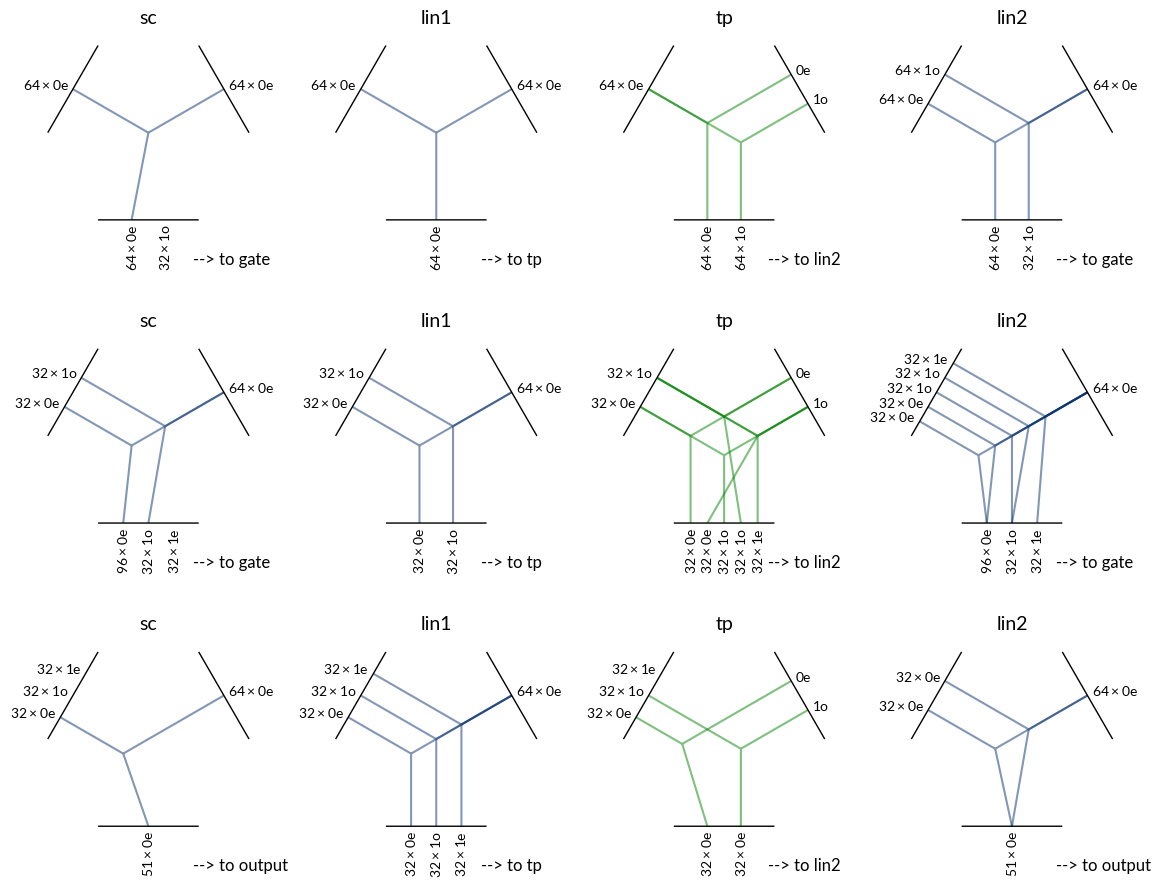

In [71]:
# visualize tensor products of the model
visualize_layers(model)

### Training
The model is trained using a mean-squared error loss function with an Adam optimizer.

In [72]:
def custom_loss(pred, target, w_cos=0.7, w_mse=0.3, eps=1e-8):
    pred = F.relu(pred)
    
    pred_norm = torch.sqrt(torch.sum(pred * pred, dim=1) + eps)
    target_norm = torch.sqrt(torch.sum(target * target, dim=1) + eps)
    
    pred_normalized = pred / pred_norm.unsqueeze(1)
    target_normalized = target / target_norm.unsqueeze(1)
    
    cos_sim = torch.sum(pred_normalized * target_normalized, dim=1)
    cos_loss = torch.mean(1 - cos_sim)
    
    mse_loss = F.mse_loss(pred, target)
    
    return w_cos * cos_loss + w_mse * mse_loss


In [75]:
opt = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.96)

loss_fn = custom_loss
# loss_fn = torch.nn.MSELoss()
loss_fn_mae = torch.nn.L1Loss()

In [76]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print('torch device:' , device)
run_name = 'model'

print(run_name)

torch device: cpu
model


In [ ]:
model.pool = True
train(model, opt, dataloader_train, dataloader_valid, loss_fn, loss_fn_mae, run_name,
      max_iter=5, scheduler=scheduler, device=device)

100%|██████████| 1192/1192 [01:42<00:00, 11.67it/s]                             


Iteration    1   train loss =   0.0586   valid loss =   0.0836   elapsed time = 00:01:42


100%|██████████| 1192/1192 [01:52<00:00, 10.64it/s]                             


Iteration    2   train loss =   0.0502   valid loss =   0.0724   elapsed time = 00:04:02


 92%|█████████▏| 1102/1192 [01:37<00:06, 13.37it/s]                             

In [ ]:
# load pre-trained model and plot its training history
run_name = 'model'

history = torch.load(run_name + '.torch', map_location=device)['history']
steps = [d['step'] + 1 for d in history]
loss_train = [d['train']['loss'] for d in history]
loss_valid = [d['valid']['loss'] for d in history]

fig, ax = plt.subplots(figsize=(6,5))
ax.plot(steps, loss_train, 'o-', label="Training", color=colors['train'])
ax.plot(steps, loss_valid, 'o-', label="Validation", color=colors['valid'])
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.legend(frameon=False);

### Results
We evaluate our model by visualizing the predicted and true DoS in each error quartile. We further compare the hidden features learned for each node to the partial DoS.

In [ ]:
# predict on all data
model.load_state_dict(torch.load(run_name + '.torch', map_location=device)['state'])
model.pool = True

dataloader = tg.loader.DataLoader(df['data'].values, batch_size=64)
df['mse'] = 0.
df['phdos_pred'] = np.empty((len(df), 0)).tolist()

model.to(device)
model.eval()
with torch.no_grad():
    i0 = 0
    for i, d in tqdm(enumerate(dataloader), total=len(dataloader), bar_format=bar_format):
        d.to(device)
        output = model(d)
        loss = F.mse_loss(output, d.phdos, reduction='none').mean(dim=-1).cpu().numpy()
        df.loc[i0:i0 + len(d.phdos) - 1, 'phdos_pred'] = [[k] for k in output.cpu().numpy()]
        df.loc[i0:i0 + len(d.phdos) - 1, 'mse'] = loss
        i0 += len(d.phdos)
        
df['phdos_pred'] = df['phdos_pred'].map(lambda x: x[0])

In [ ]:
plot_predictions(df, idx_train, 'Training')

In [ ]:
plot_predictions(df, idx_valid, 'Validation')

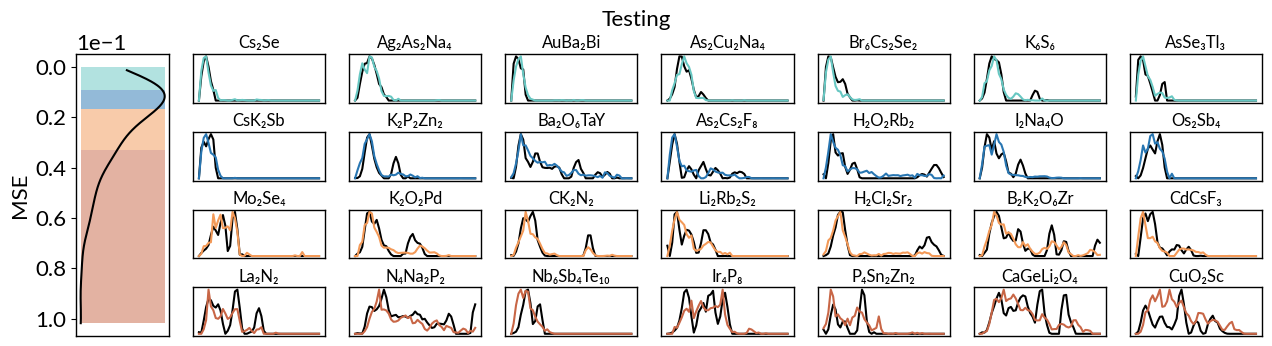

In [53]:
plot_predictions(df, idx_test, 'Testing')

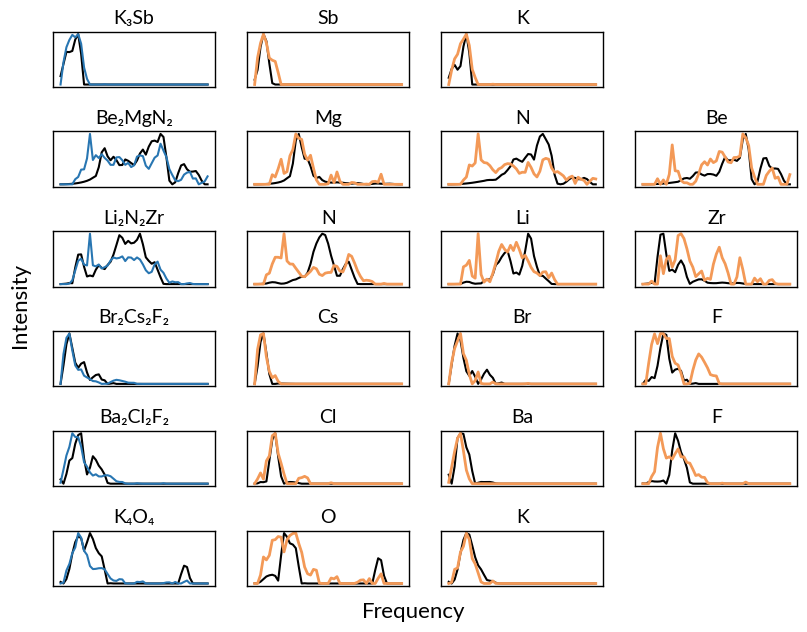

In [54]:
# compare to partial DoS
model.load_state_dict(torch.load(run_name + '.torch', map_location=device)['state'])
model.pool = False

# plot example predicted and true partial dos
plot_partials(model, df, idx_train, device=device)

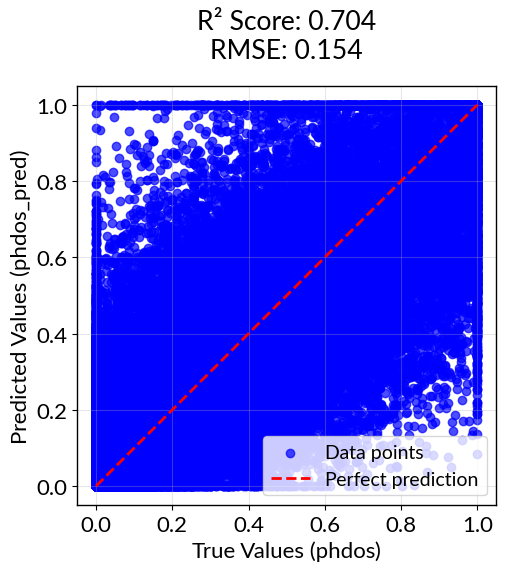


Analysis Results:
--------------------
R² Score: 0.7036
MSE: 0.0237
RMSE: 0.1541
MAE: 0.0867
Number of samples: 77622


In [66]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

def analyze_r2_score(df, true_col='phdos', pred_col='phdos_pred', plot=True):
    """
    Analyze and visualize R² score for predicted vs true values.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the true and predicted values
    true_col : str
        Name of the column containing true values (default: 'phdos')
    pred_col : str
        Name of the column containing predicted values (default: 'phdos_pred')
    plot : bool
        Whether to create a visualization (default: True)
        
    Returns:
    --------
    dict
        Dictionary containing R² score and additional statistics
    """
    def flatten_column(column):
        """Flatten a column of arrays into a 1D array."""
        try:
            return np.concatenate(column.values)
        except ValueError as e:
            print(f"Error flattening column: {e}")
            return None

    # Flatten columns
    flattened_true = flatten_column(df[true_col])
    flattened_pred = flatten_column(df[pred_col])
    
    # Validate data
    if flattened_true is None or flattened_pred is None:
        raise ValueError("Could not flatten columns. Check if they contain valid arrays.")
    
    if flattened_true.shape != flattened_pred.shape:
        raise ValueError(f"Shape mismatch: True values {flattened_true.shape} vs Predicted values {flattened_pred.shape}")
    
    # Calculate R² score
    r2 = r2_score(flattened_true, flattened_pred)
    
    # Calculate additional statistics
    mse = np.mean((flattened_true - flattened_pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(flattened_true - flattened_pred))
    
    # Create visualization if requested
    if plot:
        plt.figure(figsize=(10, 6))
        plt.scatter(flattened_true, flattened_pred, alpha=0.7, color='blue', label='Data points')
        
        # Add perfect prediction line
        min_val = min(flattened_true.min(), flattened_pred.min())
        max_val = max(flattened_true.max(), flattened_pred.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', 
                 lw=2, label='Perfect prediction')
        
        # Add labels and title
        plt.title(f'R² Score: {r2:.3f}\nRMSE: {rmse:.3f}', pad=20)
        plt.xlabel(f'True Values ({true_col})')
        plt.ylabel(f'Predicted Values ({pred_col})')
        
        # Add legend and grid
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Make plot square
        plt.axis('square')
        
        # Show plot
        plt.tight_layout()
        plt.show()
    
    # Return results
    results = {
        'r2_score': r2,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'n_samples': len(flattened_true)
    }
    
    return results
    
# Call the function with your DataFrame
results = analyze_r2_score(df)

# Print all the results
print("\nAnalysis Results:")
print("-" * 20)
print(f"R² Score: {results['r2_score']:.4f}")
print(f"MSE: {results['mse']:.4f}")
print(f"RMSE: {results['rmse']:.4f}")
print(f"MAE: {results['mae']:.4f}")
print(f"Number of samples: {results['n_samples']}")